In [1]:
import pyvista
import PyQt5

import numpy as np
import mne
from mne.datasets import sample
from mne.minimum_norm import (apply_inverse, apply_inverse_epochs,
                              read_inverse_operator, make_inverse_operator)
from mne.connectivity import seed_target_indices, spectral_connectivity

print(__doc__)

Automatically created module for IPython interactive environment


### Choose location & vertice index

In [27]:
location = "Aud-lh"
vertice_index = 2

# EEG analyzation

### Load data and drop MEG samples

In [28]:
data_path = sample.data_path()
subjects_dir = data_path + '/subjects'
print(data_path)

fname_fwd = data_path + '/MEG/sample/sample_audvis-eeg-oct-6-fwd.fif'
fname_cov = data_path + '/MEG/sample/sample_audvis-cov.fif'
fname_evo = data_path + '/MEG/sample/sample_audvis-ave.fif'
fname_raw = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
fname_event = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'

# variable defined in cell above
label_name = location
fname_label = data_path + '/MEG/sample/labels/%s.label' % label_name

event_id, tmin, tmax = 1, -0.2, 0.5
method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)

# read forward solution 
fwd = mne.read_forward_solution(fname_fwd)

# noise covariance matrix
noise_cov = mne.read_cov(fname_cov)

# evoked data for info
evoked = mne.read_evokeds(fname_evo, 0)
inverse_operator = make_inverse_operator(evoked.info, fwd, noise_cov,
                                         loose=0.2, depth=0.8)

label = mne.read_label(fname_label)
raw = mne.io.read_raw_fif(fname_raw)
events = mne.read_events(fname_event)

# Remove EEG 053 channel in case 60 elements are required
raw.info["bads"].remove("EEG 053")
raw.info["bads"].remove("MEG 2443")


# pick MEG channels.
picks = mne.pick_types(raw.info, eeg=True, meg=False)
# Read epochs.
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                    baseline=(None, 0),
                    reject=dict(eeg=150e-6))

/home/tor/mne_data/MNE-sample-data
Reading forward solution from /home/tor/mne_data/MNE-sample-data/MEG/sample/sample_audvis-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
    366 x 366 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
Reading /home/tor/mne_data/MNE-sample-data/MEG/sample/sample_audvis-ave.fif ...
    Read a total of 4 projection items

In [29]:
print(f"Number of elements in picks: {len(picks)}")

Number of elements in picks: 60


In [30]:
snr = 3.0
lambda2 = 1.0 / snr ** 2
evoked = epochs.average()
stc = apply_inverse(evoked, inverse_operator, lambda2, method,
                    pick_ori="normal")

# Restrict the source estimate to the label in the left auditory cortex.
stc_label = stc.in_label(label)

# Find number and index of vertex with most power.
src_pow = np.sum(stc_label.data ** 2, axis=1)

print(f"Vertex index with most power: {np.argmax(src_pow)}")

# Uncomment (& comment out next line) if I want to get the index with highest power
# seed_vertno = stc_label.vertices[0][np.argmax(src_pow)]

# variable "vertice_index" defined in cell above
# NOTE: For the first index: if location == lh --> 0 ; if location == rh --> 1 !
seed_vertno = stc_label.vertices[0][vertice_index]

# Search for index in orig stc
seed_idx = np.searchsorted(stc.vertices[0], seed_vertno)  

# Generate index parameter for seed-based connectivity analysis.
n_sources = stc.data.shape[0]
indices = seed_target_indices([seed_idx], np.arange(n_sources))

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 72
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 58 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "1"...
    Picked 59 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  87.7% variance
    dSPM...
[done]
Vertex index with most power: 7


In [31]:
snr = 1.0  # use lower SNR for single epochs
lambda2 = 1.0 / snr ** 2
stcs = apply_inverse_epochs(epochs, inverse_operator, lambda2, method,
                            pick_ori="normal", return_generator=True)

In [32]:
fmin = (8., 13.)
fmax = (13., 30.)
sfreq = raw.info['sfreq']  # the sampling frequency

coh_eeg, freqs, times, n_epochs, n_tapers = spectral_connectivity(
    stcs, method='coh', mode='fourier', indices=indices,
    sfreq=sfreq, fmin=fmin, fmax=fmax, faverage=True, n_jobs=1)

print('Frequencies in Hz over which coherence was averaged for alpha: ')
print(freqs[0])
print('Frequencies in Hz over which coherence was averaged for beta: ')
print(freqs[1])

Connectivity computation...
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 58 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 59 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 72 (at most)
    computing connectivity for 7498 connections
    using t=-0.200s..0.499s for estimation (106 points)
    computing connectivity for the bands:
     band 1: 8.5Hz..12.7Hz (4 points)
     band 2: 14.2Hz..29.7Hz (12 points)
    connectivity scores will be averaged for each band
    using FFT with a Hanning window to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
Processing epoch : 2 / 72 (at most)
    computing connectiv

### Visualize

In [33]:
# %matplotlib inline

# tmin = np.mean(freqs[0])
# tstep = np.mean(freqs[1]) - tmin
# coh_stc = mne.SourceEstimate(coh_eeg, vertices=stc.vertices, tmin=1e-3 * tmin,
#                              tstep=1e-3 * tstep, subject='sample')

# # Now we can visualize the coherence using the plot method.
# brain = coh_stc.plot('sample', 'inflated', 'both',
#                      time_label='Coherence %0.1f Hz',
#                      subjects_dir=subjects_dir,
#                      clim=dict(kind='value', lims=(0.25, 0.4, 0.65)))
# brain.show_view('lateral')

# MEG analyzation

In [34]:
data_path = sample.data_path()
subjects_dir = data_path + '/subjects'
fname_inv = data_path + '/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif'
fname_raw = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
fname_event = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'
# variable defined in cell above
label_name = location
fname_label = data_path + '/MEG/sample/labels/%s.label' % label_name

event_id, tmin, tmax = 1, -0.2, 0.5
method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)

# Load data.
inverse_operator = read_inverse_operator(fname_inv)
label = mne.read_label(fname_label)
raw = mne.io.read_raw_fif(fname_raw)
events = mne.read_events(fname_event)

# Add a bad channel.
raw.info['bads'] += ['MEG 2443']

# pick MEG channels.
picks = mne.pick_types(raw.info, meg=True, eeg=False, stim=False, eog=True,
                       exclude='bads')

# Read epochs.
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                    baseline=(None, 0),
                    reject=dict(mag=4e-12, grad=4000e-13, eog=150e-6))

Reading inverse operator decomposition from /home/tor/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Noise covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 6) found.
    Orientation priors read.
    22494 x 22494 diagonal covariance (kind = 5) found.
    Depth priors read.
    Did not find the desired covariance matrix (kind = 3)
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch

In [35]:
snr = 3.0
lambda2 = 1.0 / snr ** 2
evoked = epochs.average()
stc = apply_inverse(evoked, inverse_operator, lambda2, method,
                    pick_ori="normal")

# Restrict the source estimate to the label in the left auditory cortex.
stc_label = stc.in_label(label)

# Find number and index of vertex with most power.
src_pow = np.sum(stc_label.data ** 2, axis=1)
print(f"Vertex index with most power: {np.argmax(src_pow)}")

#seed_vertno = stc_label.vertices[0][np.argmax(src_pow)]
# variable "vertice index" defined in cell above
seed_vertno = stc_label.vertices[0][vertice_index]

seed_idx = np.searchsorted(stc.vertices[0], seed_vertno)  # index in orig stc

# Generate index parameter for seed-based connectivity analysis.
n_sources = stc.data.shape[0]
indices = seed_target_indices([seed_idx], np.arange(n_sources))

    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 55
    Created the regularized inverter
    Created an SSP operator (subspace 

In [36]:
snr = 1.0  # use lower SNR for single epochs
lambda2 = 1.0 / snr ** 2
stcs = apply_inverse_epochs(epochs, inverse_operator, lambda2, method,
                            pick_ori="normal", return_generator=True)

In [37]:
fmin = (8., 13.)
fmax = (13., 30.)
sfreq = raw.info['sfreq']  # the sampling frequency

coh_meg, freqs, times, n_epochs, n_tapers = spectral_connectivity(
    stcs, method='coh', mode='fourier', indices=indices,
    sfreq=sfreq, fmin=fmin, fmax=fmax, faverage=True, n_jobs=1)

print('Frequencies in Hz over which coherence was averaged for alpha: ')
print(freqs[0])
print('Frequencies in Hz over which coherence was averaged for beta: ')
print(freqs[1])


Connectivity computation...
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 3)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 305 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 72 (at most)
    computing connectivity for 7498 connections
    using t=-0.200s..0.499s for estimation (106 points)
    computing connectivity for the bands:
     band 1: 8.5Hz..12.7Hz (4 points)
     band 2: 14.2Hz..29.7Hz (12 points)
    connectivity scores will be averaged for each band
    using FFT with a Hanning window to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
Processing epoch : 2 / 72 (at most)
    computing connect

In [46]:
tmin = np.mean(freqs[0])
tstep = np.mean(freqs[1]) - tmin
coh_stc = mne.SourceEstimate(coh_meg, vertices=stc.vertices, tmin=1e-3 * tmin,
                             tstep=1e-3 * tstep, subject='sample')

# Now we can visualize the coherence using the plot method.
brain = coh_stc.plot('sample', 'inflated', 'both',
                     time_label='Coherence %0.1f Hz',
                     subjects_dir=subjects_dir,
                     clim=dict(kind='value', lims=(0.25, 0.4, 0.65)))
brain.show_view('lateral')

### Save  previously computed coherences

In [40]:
# Save the coherence data to .npy (numpy format)
np.save("coh_eeg_index{}_{}.npy".format(vertice_index,location), coh_eeg)
np.save("coh_meg_index{}_{}.npy".format(vertice_index,location), coh_meg)

# Analyze & save different locations 

#### EEG

In [43]:
# Cell 1
data_path = sample.data_path()
subjects_dir = data_path + '/subjects'

fname_fwd = data_path + '/MEG/sample/sample_audvis-eeg-oct-6-fwd.fif'
fname_cov = data_path + '/MEG/sample/sample_audvis-cov.fif'
fname_evo = data_path + '/MEG/sample/sample_audvis-ave.fif'
fname_raw = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
fname_event = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'

# iterate over different locations
for vertice_idx, label_name in enumerate(['Aud-lh', 'Aud-rh', 'Vis-lh', 'Vis-rh']):
    fname_label = data_path + '/MEG/sample/labels/%s.label' % label_name

    event_id, tmin, tmax = 1, -0.2, 0.5
    method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)

    # read forward solution 
    fwd = mne.read_forward_solution(fname_fwd)

    # noise covariance matrix
    noise_cov = mne.read_cov(fname_cov)

    # evoked data for info
    evoked = mne.read_evokeds(fname_evo, 0)
    inverse_operator = make_inverse_operator(evoked.info, fwd, noise_cov,
                                             loose=0.2, depth=0.8)

    label = mne.read_label(fname_label)
    raw = mne.io.read_raw_fif(fname_raw)
    events = mne.read_events(fname_event)

    # Remove EEG 053 channel in case 60 elements are required
    raw.info["bads"].remove("EEG 053")
    raw.info["bads"].remove("MEG 2443")


    # pick MEG channels.
    picks = mne.pick_types(raw.info, eeg=True, meg=False)
    # Read epochs.
    epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                        baseline=(None, 0),
                        reject=dict(eeg=150e-6))

    print(f"Number of elements in picks: {len(picks)}")

    # Cell 2

    snr = 3.0
    lambda2 = 1.0 / snr ** 2
    evoked = epochs.average()
    stc = apply_inverse(evoked, inverse_operator, lambda2, method,
                        pick_ori="normal")

    # Restrict the source estimate to the label in the left auditory cortex.
    stc_label = stc.in_label(label)

    # Find number and index of vertex with most power.
    src_pow = np.sum(stc_label.data ** 2, axis=1)
    print(f"Vertex index with most power: {np.argmax(src_pow)}")
    
    idx = np.argmax(src_pow)
    print(idx)
    print(stc_label.vertices)


    seed_vertno = stc_label.vertices[vertice_idx%2][np.argmax(src_pow)]

    # index in orig stc
    seed_idx = np.searchsorted(stc.vertices[1], seed_vertno)  

    # Generate index parameter for seed-based connectivity analysis.
    n_sources = stc.data.shape[0]
    indices = seed_target_indices([seed_idx], np.arange(n_sources))

    # Cell 3
    snr = 1.0  # use lower SNR for single epochs
    lambda2 = 1.0 / snr ** 2
    stcs = apply_inverse_epochs(epochs, inverse_operator, lambda2, method,
                                pick_ori="normal", return_generator=True)

    # Cell 4
    fmin = (8., 13.)
    fmax = (13., 30.)
    sfreq = raw.info['sfreq']  # the sampling frequency

    coh_eeg, freqs, times, n_epochs, n_tapers = spectral_connectivity(
        stcs, method='coh', mode='fourier', indices=indices,
        sfreq=sfreq, fmin=fmin, fmax=fmax, faverage=True, n_jobs=1)

    print('Frequencies in Hz over which coherence was averaged for alpha: ')
    print(freqs[0])
    print('Frequencies in Hz over which coherence was averaged for beta: ')
    print(freqs[1])

    np.save("coh_eeg_index{}_{}.npy".format(idx, label_name), coh_eeg)


0 Aud-rh
1 Aud-lh
2 Vis-rh
3 Vis-lh


#### MEG

In [16]:
data_path = sample.data_path()
subjects_dir = data_path + '/subjects'
fname_inv = data_path + '/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif'
fname_raw = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
fname_event = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'


# iterate over different locations
for vertice_idx, label_name in enumerate(['Aud-lh', 'Aud-rh', 'Vis-lh', 'Vis-rh']):
    fname_label = data_path + '/MEG/sample/labels/%s.label' % label_name

    event_id, tmin, tmax = 1, -0.2, 0.5
    method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)

    # Load data.
    inverse_operator = read_inverse_operator(fname_inv)
    label = mne.read_label(fname_label)
    raw = mne.io.read_raw_fif(fname_raw)
    events = mne.read_events(fname_event)

    # Add a bad channel.
    raw.info['bads'] += ['MEG 2443']

    # pick MEG channels.
    picks = mne.pick_types(raw.info, meg=True, eeg=False, stim=False, eog=True,
                           exclude='bads')

    # Read epochs.
    epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                        baseline=(None, 0),
                        reject=dict(mag=4e-12, grad=4000e-13, eog=150e-6))


    snr = 3.0
    lambda2 = 1.0 / snr ** 2
    evoked = epochs.average()
    stc = apply_inverse(evoked, inverse_operator, lambda2, method,
                        pick_ori="normal")

    # Restrict the source estimate to the label in the left auditory cortex.
    stc_label = stc.in_label(label)

    # Find number and index of vertex with most power.
    src_pow = np.sum(stc_label.data ** 2, axis=1)
    print(f"Vertex index with most power: {np.argmax(src_pow)}")

    seed_vertno = stc_label.vertices[vertice_idx%2][np.argmax(src_pow)]
    
    idx = np.argmax(src_pow)

    seed_idx = np.searchsorted(stc.vertices[0], seed_vertno)  # index in orig stc

    # Generate index parameter for seed-based connectivity analysis.
    n_sources = stc.data.shape[0]
    indices = seed_target_indices([seed_idx], np.arange(n_sources))

    snr = 1.0  # use lower SNR for single epochs
    lambda2 = 1.0 / snr ** 2
    stcs = apply_inverse_epochs(epochs, inverse_operator, lambda2, method,
                                pick_ori="normal", return_generator=True)

    fmin = (8., 13.)
    fmax = (13., 30.)
    sfreq = raw.info['sfreq']  # the sampling frequency

    coh_meg, freqs, times, n_epochs, n_tapers = spectral_connectivity(
        stcs, method='coh', mode='fourier', indices=indices,
        sfreq=sfreq, fmin=fmin, fmax=fmax, faverage=True, n_jobs=1)

    print('Frequencies in Hz over which coherence was averaged for alpha: ')
    print(freqs[0])
    print('Frequencies in Hz over which coherence was averaged for beta: ')
    print(freqs[1])


    np.save("coh_meg_index{}_{}.npy".format(idx, label_name), coh_meg)

Reading inverse operator decomposition from /home/tor/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Noise covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 6) found.
    Orientation priors read.
    22494 x 22494 diagonal covariance (kind = 5) found.
    Depth priors read.
    Did not find the desired covariance matrix (kind = 3)
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch

    Rejecting  epoch based on EOG : ['EOG 061']
Processing epoch : 45 / 72 (at most)
    computing connectivity for epoch 45
    Rejecting  epoch based on EOG : ['EOG 061']
Processing epoch : 46 / 72 (at most)
    computing connectivity for epoch 46
Processing epoch : 47 / 72 (at most)
    computing connectivity for epoch 47
Processing epoch : 48 / 72 (at most)
    computing connectivity for epoch 48
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
Processing epoch : 49 / 72 (at most)
    computing connectivity for epoch 49
Processing epoch : 50 / 72 (at most)
    computing connectivity for epoch 50
Processing epoch : 51 / 72 (at most)
    computing connectivity for epoch 51
Processing epoch : 52 / 72 (at most)
    computing connectivity for epoch 52
Processing epoch : 53 / 72 (at most)
    computing connectivity for epoch 53
Processing epoch : 54 / 72 (at most)
    computing connectivity for epoch 54
Processing epoch : 55 / 72 (at most)
 

Processing epoch : 31 / 72 (at most)
    computing connectivity for epoch 31
    Rejecting  epoch based on EOG : ['EOG 061']
Processing epoch : 32 / 72 (at most)
    computing connectivity for epoch 32
Processing epoch : 33 / 72 (at most)
    computing connectivity for epoch 33
    Rejecting  epoch based on EOG : ['EOG 061']
Processing epoch : 34 / 72 (at most)
    computing connectivity for epoch 34
Processing epoch : 35 / 72 (at most)
    computing connectivity for epoch 35
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
Processing epoch : 36 / 72 (at most)
    computing connectivity for epoch 36
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
Processing epoch : 37 / 72 (at most)
    computing connectivity for epoch 37
Processing epoch : 38 / 72 (at most)
    computing connectivity for epoch 38
Processing epoch : 39 / 72 (at most)
    computing connectivity for epoch 39
Processing epoch : 

    computing connectivity for epoch 15
Processing epoch : 16 / 72 (at most)
    computing connectivity for epoch 16
Processing epoch : 17 / 72 (at most)
    computing connectivity for epoch 17
    Rejecting  epoch based on EOG : ['EOG 061']
Processing epoch : 18 / 72 (at most)
    computing connectivity for epoch 18
Processing epoch : 19 / 72 (at most)
    computing connectivity for epoch 19
Processing epoch : 20 / 72 (at most)
    computing connectivity for epoch 20
    Rejecting  epoch based on EOG : ['EOG 061']
Processing epoch : 21 / 72 (at most)
    computing connectivity for epoch 21
Processing epoch : 22 / 72 (at most)
    computing connectivity for epoch 22
Processing epoch : 23 / 72 (at most)
    computing connectivity for epoch 23
    Rejecting  epoch based on MAG : ['MEG 1711']
Processing epoch : 24 / 72 (at most)
    computing connectivity for epoch 24
Processing epoch : 25 / 72 (at most)
    computing connectivity for epoch 25
Processing epoch : 26 / 72 (at most)
    comp

    connectivity scores will be averaged for each band
    using FFT with a Hanning window to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
Processing epoch : 2 / 72 (at most)
    computing connectivity for epoch 2
Processing epoch : 3 / 72 (at most)
    computing connectivity for epoch 3
Processing epoch : 4 / 72 (at most)
    computing connectivity for epoch 4
Processing epoch : 5 / 72 (at most)
    computing connectivity for epoch 5
Processing epoch : 6 / 72 (at most)
    computing connectivity for epoch 6
Processing epoch : 7 / 72 (at most)
    computing connectivity for epoch 7
Processing epoch : 8 / 72 (at most)
    computing connectivity for epoch 8
Processing epoch : 9 / 72 (at most)
    computing connectivity for epoch 9
Processing epoch : 10 / 72 (at most)
    computing connectivity for epoch 10
    Rejecting  epoch based on EOG : ['EOG 061']
Processing epoch : 11 / 72 (at most)
    computing connectivity for epo

### Load previously computed data & analyze 

In [41]:
# If needed: load coherence data
coh_eeg = np.load("coh_eeg_index2_Aud-lh.npy")
coh_meg = np.load("coh_meg_index2_Aud-lh.npy")

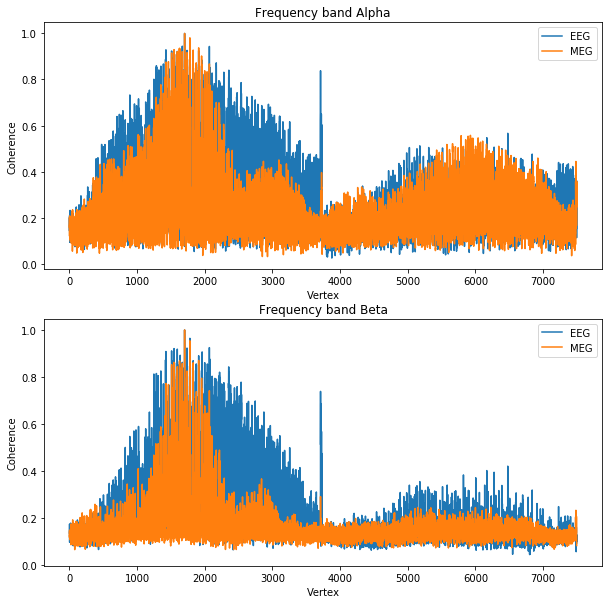

In [42]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(2,1,1)
plt.plot(coh_eeg[:,0], label="EEG")
plt.plot(coh_meg[:,0], label="MEG")
ax.set_xlabel("Vertex")
ax.set_ylabel("Coherence")
plt.title("Frequency band Alpha")
plt.legend()

ax = plt.subplot(2,1,2)
plt.plot(coh_eeg[:,1], label="EEG")
plt.plot(coh_meg[:,1], label="MEG")
plt.title("Frequency band Beta")
ax.set_xlabel("Vertex")
ax.set_ylabel("Coherence")
plt.legend()

Text(0, 0.5, 'Coherence')

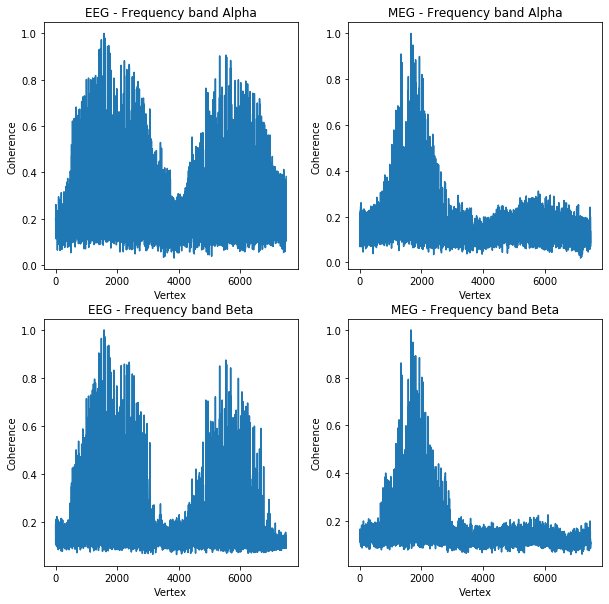

In [24]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(2,2,1)
plt.plot(coh_eeg[:,0])
ax.set_xlabel("Vertex")
ax.set_ylabel("Coherence")
plt.title("EEG - Frequency band Alpha")

ax = plt.subplot(2,2,2)
plt.plot(coh_meg[:,0])
ax.set_xlabel("Vertex")
ax.set_ylabel("Coherence")
plt.title("MEG - Frequency band Alpha")


ax = plt.subplot(2,2,3)
plt.plot(coh_eeg[:,1], label="EEG")
plt.title("EEG - Frequency band Beta")
ax.set_xlabel("Vertex")
ax.set_ylabel("Coherence")

ax = plt.subplot(2,2,4)
plt.plot(coh_meg[:,1])
plt.title("MEG - Frequency band Beta")
ax.set_xlabel("Vertex")
ax.set_ylabel("Coherence")


In [44]:
print("Statistics frequency band Alpha (EEG first, MEG second)")
for ray in [coh_eeg[:,0], coh_meg[:,0]]:
    print(f"\taverage: {np.mean(ray)}")
    print(f"\tmedian: {np.median(ray)}")
    print(f"\tvariance: {np.var(ray)}")
    print(f"\tmax value: {np.max([x for x in ray if x < 0.999999])}")
    print(f"\tmin value: {np.min(ray)}")
    print(f"\tstd value: {np.std(ray)}")
    print("\n")
    
print("Statistics frequency band Beta (EEG first, MEG second)")
for ray in [coh_eeg[:,1], coh_meg[:,1]]:
    print(f"\taverage: {np.mean(ray)}")
    print(f"\tmedian: {np.median(ray)}")
    print(f"\tvariance: {np.var(ray)}")
    print(f"\tmax value: {np.max([x for x in ray if x < 0.999999])}")
    print(f"\tmin value: {np.min(ray)}")
    print(f"\tstd value: {np.std(ray)}")
    print("\n")
    

Statistics frequency band Alpha (EEG first, MEG second)
	average: 0.2578233910092916
	median: 0.21095283888396574
	variance: 0.024674206776552462
	max value: 0.9714752959736517
	min value: 0.02442515676944656
	std value: 0.15708025584570603


	average: 0.2261358003118072
	median: 0.19276855620749508
	variance: 0.01746865123155628
	max value: 0.9808833847936964
	min value: 0.030792270519502164
	std value: 0.13216902523494783


Statistics frequency band Beta (EEG first, MEG second)
	average: 0.1970518896243716
	median: 0.14204155488526035
	variance: 0.02033785799815293
	max value: 0.9642914169668712
	min value: 0.042921245368065776
	std value: 0.14261086213242288


	average: 0.15568768512882492
	median: 0.13646939603252276
	variance: 0.007127569972316688
	max value: 0.9537447357731921
	min value: 0.06388461871779987
	std value: 0.08442493691035065




In [21]:
coh_eeg.shape

(7498, 2)